# Анализ убытков приложения ProcrastinatePRO+

**Описание проекта**: несмотря на огромные вложения в рекламу, последние несколько месяцев компания-разработчик развлекательного приложения Procrastinate Pro+ терпит убытки. Задача — разобраться в причинах и помочь компании выйти в плюс. Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года. 

**Описание данных**:

Лог сервера с информацией о посещениях сайта - `visits_info_short.csv`, его структура:
- `User Id` — уникальный идентификатор пользователя;
- `Region` — страна пользователя;
- `Device` — тип устройства пользователя;
- `Channel` — идентификатор источника перехода;
- `Session Start` — дата и время начала сессии;
- `Session End` — дата и время окончания сессии.

Информация о заказах - `orders_info_short.csv`, его структура:
- `User Id` — уникальный идентификатор пользователя;
- `Event Dt` — дата и время покупки;
- `Revenue` — сумма заказа.

Информация о расходах на рекламу - `costs_info_short.csv`, его структура:
- `dt` — дата проведения рекламной кампании;
- `Channel` — идентификатор рекламного источника;
- `costs` — расходы на эту кампанию.


## Загрузка и предобработка данных

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from matplotlib import pyplot as plt

In [2]:
pth1_visits = 'visits_info_short.csv'
pth1_orders = 'orders_info_short.csv'
pth1_costs = 'costs_info_short.csv'

# сюда можно ввести ваш адрес к датасету
pth2_visits = '' 
pth2_orders = '' 
pth2_costs = '' 

try:
    visits = pd.read_csv(pth1_visits)
    orders = pd.read_csv(pth1_orders)
    costs = pd.read_csv(pth1_costs)
except FileNotFoundError:
    visits = pd.read_csv(pth2_visits)
    orders = pd.read_csv(pth2_orders)
    costs = pd.read_csv(pth2_costs)
except:
    print('Something is wrong')

In [3]:
display(visits.info(), orders.info(), costs.info(), 
        visits.head(), orders.head(), costs.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   

None

None

None

User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

In [4]:
# переименуем столбцы
visits = visits.rename(columns={'User Id': 'user_id', 'Region': 'region', 'Device': 'device', 'Channel': 'channel', 
                       'Session Start': 'session_st', 'Session End': 'session_end'})
orders = orders.rename(columns={'User Id': 'user_id', 'Event Dt': 'event_dt', 'Revenue': 'revenue'})
costs = costs.rename(columns={'Channel': 'channel'})

# столбцы с датами приведем к типу Datetime
visits['session_st'] = pd.to_datetime(visits['session_st'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt'])

In [5]:
# проверим данные на наличие пропусков и дубликатов
display(visits.duplicated().sum(), orders.duplicated().sum(), costs.duplicated().sum(),
        visits.isna().sum(), orders.isna().sum(), costs.isna().sum())

0

0

0

user_id        0
region         0
device         0
channel        0
session_st     0
session_end    0
dtype: int64

user_id     0
event_dt    0
revenue     0
dtype: int64

dt         0
channel    0
costs      0
dtype: int64

In [6]:
# проверим данные на наличие неявных дубликатов
display(sorted(visits['region'].unique()), 
        sorted(visits['device'].unique()), 
        sorted(visits['channel'].unique()), 
        sorted(costs['channel'].unique()))

['France', 'Germany', 'UK', 'United States']

['Android', 'Mac', 'PC', 'iPhone']

['AdNonSense',
 'FaceBoom',
 'LeapBob',
 'MediaTornado',
 'OppleCreativeMedia',
 'RocketSuperAds',
 'TipTop',
 'WahooNetBanner',
 'YRabbit',
 'lambdaMediaAds',
 'organic']

['AdNonSense',
 'FaceBoom',
 'LeapBob',
 'MediaTornado',
 'OppleCreativeMedia',
 'RocketSuperAds',
 'TipTop',
 'WahooNetBanner',
 'YRabbit',
 'lambdaMediaAds']

In [7]:
# оценим наличие аномалий
display(orders['revenue'].describe(), 
        costs['costs'].describe())

count    40212.000000
mean         5.370608
std          3.454208
min          4.990000
25%          4.990000
50%          4.990000
75%          4.990000
max         49.990000
Name: revenue, dtype: float64

count    1800.000000
mean       58.609611
std       107.740223
min         0.800000
25%         6.495000
50%        12.285000
75%        33.600000
max       630.000000
Name: costs, dtype: float64

Выводы: 
- В данных отсутствуют пропуски и дубликаты.
- Для развлекательного приложения средняя продолжительности пользовательских сессий достаточно короткая, в среднем, 5 минут. Есть и длительные сессии, около 50 минут, но их очень мало.
- Компания явно экспериментировала с рекламой; ее стоимость варьируется от 0.8 доларов до 630. За среднюю стоимость следует принять ее медианное значение - 58 долларов.

## Исследовательский анализ данных

In [8]:
# функция для создания пользовательских профилей

def get_profiles(visits, orders, events, costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        visits.sort_values(by=['user_id', 'session_st'])
        .groupby('user_id')
        .agg(
            {
                'session_st': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_st': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    costs['dt'] = costs['dt'].dt.date
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

events = None # других событий, кроме покупок, нет, None — чтобы не «сломать» get_profiles()

In [9]:
# создадим пользовательские профили
users = get_profiles(visits, orders, events, costs) 
display(users.info(), users.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150008 entries, 0 to 150007
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           150008 non-null  int64         
 1   first_ts          150008 non-null  datetime64[ns]
 2   channel           150008 non-null  object        
 3   device            150008 non-null  object        
 4   region            150008 non-null  object        
 5   dt                150008 non-null  object        
 6   month             150008 non-null  datetime64[ns]
 7   payer             150008 non-null  bool          
 8   acquisition_cost  150008 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 10.4+ MB


None

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769

In [10]:
# найдем минимальную и максимальную даты привлечения пользователей
dt_min = users['dt'].min()
dt_max = users['dt'].max()
print(f'Минимальная дата привлечения пользователей: {dt_min}.\nМаксимальная дата привлечения пользователей: {dt_max}.')

Минимальная дата привлечения пользователей: 2019-05-01.
Максимальная дата привлечения пользователей: 2019-10-27.


In [11]:
# изучим страны, устройства и каналы привлечения пользователей
regions = (
    users.groupby('region')
        .agg(
            {
                'user_id': 'count',
                'payer': 'mean'
            }
        )
        .rename(columns={'user_id': 'count_user', 'payer': 'part_payer'})
        .reset_index()
    )

devices = (
    users.groupby('device')
        .agg(
            {
                'user_id': 'count',
                'payer': 'mean'
            }
        )
        .rename(columns={'user_id': 'count_user', 'payer': 'part_payer'})
        .reset_index()
    )

channels = (
    users.groupby('channel')
        .agg(
            {
                'user_id': 'count',
                'payer': 'mean'
            }
        )
        .rename(columns={'user_id': 'count_user', 'payer': 'part_payer'})
        .reset_index()
    )

# count_user - количество пользователей 
# part_payer - доля платящих пользователей
display( regions.sort_values(by='part_payer', ascending=False).round(3),
        devices.sort_values(by='part_payer', ascending=False).round(3),
        channels.sort_values(by='part_payer', ascending=False).round(3))


region  count_user  part_payer
3  United States      100002       0.069
1        Germany       14981       0.041
2             UK       17575       0.040
0         France       17450       0.038

device  count_user  part_payer
1      Mac       30042       0.064
3   iPhone       54479       0.062
0  Android       35032       0.059
2       PC       30455       0.050

channel  count_user  part_payer
1             FaceBoom       29144       0.122
0           AdNonSense        3880       0.113
9       lambdaMediaAds        2149       0.105
6               TipTop       19561       0.096
5       RocketSuperAds        4448       0.079
7       WahooNetBanner        8553       0.053
8              YRabbit        4312       0.038
3         MediaTornado        4364       0.036
2              LeapBob        8553       0.031
4   OppleCreativeMedia        8605       0.027
10             organic       56439       0.021

In [12]:
# проверим принадлежность привлеченных пользователей из США к источникам FaceBoom или TipTop

users_no_organic = users.query('channel != "organic"') # исключаем органических пользователей

df1 = users_no_organic.query('region == "United States"')
df2 = users_no_organic.query('region == "United States" & (channel == "FaceBoom" | channel == "TipTop")')
df_per = round((df2.shape[0]*100/df1.shape[0]), 2)

print(f'Принадлежность привлеченных пользователей из США к источникам FaceBoom или TipTop составляет {df_per}%.')

Принадлежность привлеченных пользователей из США к источникам FaceBoom или TipTop составляет 78.77%.


In [13]:
# а также, проверим их принадлежность к использованию устройств Mac или iPhone
df3 = users_no_organic.query('region == "United States"')
df4 = users_no_organic.query('region == "United States" & (device == "iPhone" | device == "Mac")')
df_per = round((df4.shape[0]*100/df3.shape[0]), 2)

print(f'Принадлежность привлеченных пользователей из США к использованию устройств Mac или iPhone составляет {df_per}%.')

Принадлежность привлеченных пользователей из США к использованию устройств Mac или iPhone составляет 69.5%.


Выводы:

- Период, за который собраны данные: с 01.05.2019 по 27.10.2019.
- Число органических пользователей превышает число пользователей, привлеченных любым, из используемых компанией, каналом; однако, доля платящих пользователей среди органиков очень мала, всего - 2.1%.
- Портрет среднестатистического платящего пользователя: страна, из которой он пришел - США; используемое устройство - Mac или iPhone; источник, который его привлек - FaceBoom или TipTop.

## Маркетинговый анализ данных

In [14]:
# посчитаем общую сумму расходов на маркетинг
costs_total = round((costs['costs'].sum()))
print(f'Общая сумма расходов на маркетинг составляет {costs_total} долларов.')

Общая сумма расходов на маркетинг составляет 105497 долларов.


In [15]:
# распределение расходов среди рекламных источников

costs_channel = (
    costs.groupby('channel')
        .agg(
            {
                'costs': 'sum'
            }
        )
        .rename(columns={'costs': 'sum_costs'})
        .reset_index()
    )
costs_channel['%_of_total_costs'] = round((costs_channel['sum_costs']/costs_total)*100, 2)

display(costs_channel.sort_values(by='sum_costs', ascending=False))

channel  sum_costs  %_of_total_costs
6              TipTop   54751.30             51.90
1            FaceBoom   32445.60             30.75
7      WahooNetBanner    5151.00              4.88
0          AdNonSense    3911.25              3.71
4  OppleCreativeMedia    2151.25              2.04
5      RocketSuperAds    1833.00              1.74
2             LeapBob    1797.60              1.70
9      lambdaMediaAds    1557.60              1.48
3        MediaTornado     954.48              0.90
8             YRabbit     944.22              0.90

Вывод: Источники рекламы TipTop и FaceBoom поделили между собой большую часть маркетингового бюджета компании. Доля вложений в TipTop составляет 52%, доля вложений в FaceBoom составляет 31%.

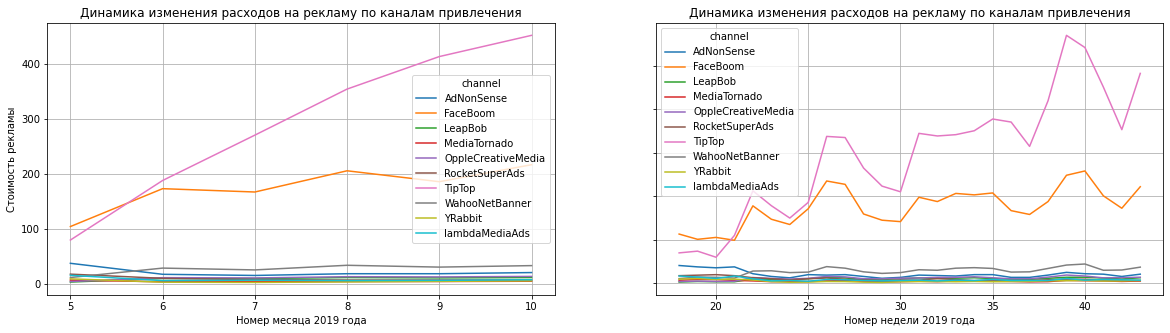

In [16]:
# динамика изменений расходов каждого источника рекламы

costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week
costs['month'] = pd.to_datetime(costs['dt']).dt.month

plt.figure(figsize=(20, 5))

report = (costs
          .pivot_table(index='month', columns='channel',values='costs', aggfunc='median')
          .fillna(0))
ax1 = report.plot(grid=True, ax=plt.subplot(1, 2, 1))
plt.xlabel('Номер месяца 2019 года')
plt.ylabel('Стоимость рекламы')
plt.title('Динамика изменения расходов на рекламу по каналам привлечения')

report = (costs
          .pivot_table(index='week', columns='channel',values='costs', aggfunc='median')
          .fillna(0))
          
ax2 = report.plot(grid=True, ax=plt.subplot(1, 2, 2), sharey=ax1)
plt.xlabel('Номер недели 2019 года')
plt.ylabel('Стоимость рекламы')
plt.title('Динамика изменения расходов на рекламу по каналам привлечения')

plt.show()


Вывод: Расходы на рекламу источника TipTop растут из месяца в месяц, засчет чего они являются самыми высокими. Расходы на рекламу источника FaceBoom ниже, чем у TipTop, но значительно выше расходов на рекламу прочих источников; динамика их изменений стабильна.

In [17]:
# средняя стоимость привлечения одного пользователя
mean_cac_user = round((users_no_organic['acquisition_cost'].mean()), 2)
print(f'Средняя стоимость привлечения одного пользователя: {mean_cac_user} доллара.')

Средняя стоимость привлечения одного пользователя: 1.13 доллара.


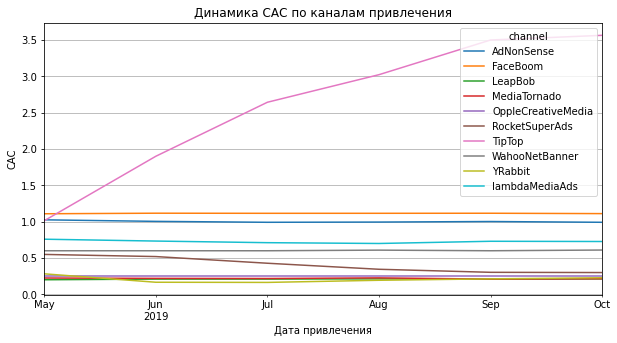

In [18]:
# динамика изменения CAC для каждого источника рекламы

users_no_organic.pivot_table(
    index='month', columns='channel', values='acquisition_cost', aggfunc='median'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('CAC')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

Выводы:

- Общая сумма расходов на маркетинг за исследуемый период, с 01.05.2019 по 27.10.2019, составляет 105497 долларов. Источники рекламы TipTop и FaceBoom поделили между собой большую часть маркетингового бюджета компании. Доля вложений в TipTop составляет 52%, доля вложений в FaceBoom составляет 31%.
- Расходы на рекламу источника TipTop растут из месяца в месяц, засчет чего они являются самыми высокими. Расходы на рекламу источника FaceBoom ниже, чем у TipTop, но значительно выше расходов на рекламу прочих источников; динамика их изменений стабильна.
- Средняя стоимость привлечения одного пользователя: 1.13 доллара.
- Динамика изменения САС всех источников рекламы, кроме источника TipTop, стабильна. Стоимость привлечения пользователей рекламного источника TipTop растет "не по дням, а по часам".

In [19]:
mean_cac_users = (
    users_no_organic.groupby('channel')
    .agg(
            {
                'acquisition_cost': 'mean'
            }
        )
        .rename(columns={'acquisition_cost': 'mean_cac'})
        .reset_index()
    )

display(round(mean_cac_users.sort_values(by='mean_cac', ascending=False), 2))

channel  mean_cac
6              TipTop      2.80
1            FaceBoom      1.11
0          AdNonSense      1.01
9      lambdaMediaAds      0.72
7      WahooNetBanner      0.60
5      RocketSuperAds      0.41
4  OppleCreativeMedia      0.25
8             YRabbit      0.22
3        MediaTornado      0.22
2             LeapBob      0.21

Вывод: Стоимость привлечения одного пользователя источником TipTop самая высокая. Стоимость привлечения одного пользователя дргими источниками, в том числе и источником FaceBoom и AdNonSense, значительно ниже.

### Общие маркетинговые метрики

In [20]:
# функция для расчёта LTV и ROI

def get_ltv(
    users,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = users.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        orders[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [21]:
# функция для сглаживания дата-фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [22]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=14):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

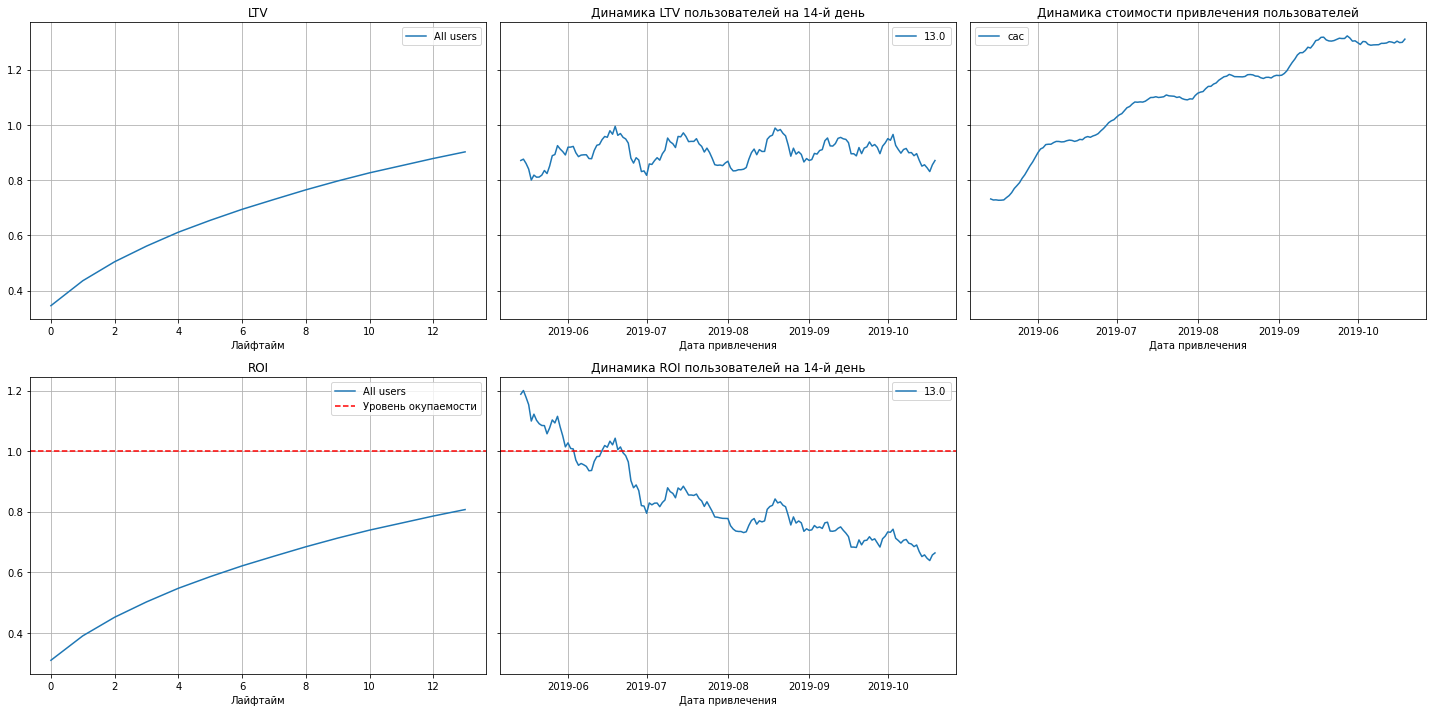

In [23]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    users_no_organic, orders, observation_date, horizon_days)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Выводы:

- Реклама не окупается; ROI в конце второй недели около ~ 80%.
- САС растет из месяца в месяц.
- На LTV влияет сезонный фактор, но этот показатель достаточно стабилен. Значит, дело не в ухудшении качества пользователей.

In [24]:
# функция для расчёта конверсии

def get_conversion(
    users,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = users.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [25]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=14):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))
    plt.tight_layout()
    plt.show() 

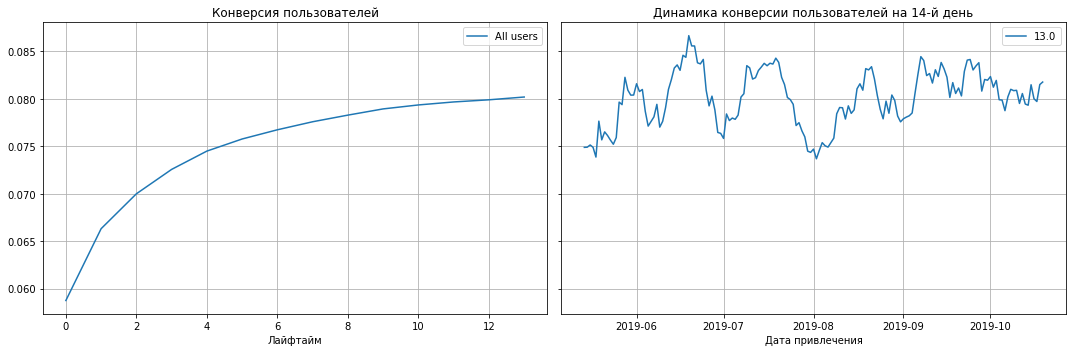

In [26]:
# считаем CR
result_raw, result_grouped, result_in_time = get_conversion(
    users_no_organic,
    orders,
    observation_date,
    horizon_days)

# строим графики
plot_conversion(result_grouped, result_in_time, horizon_days)

Выводы:

- Конверсия стабильно растет.
- Конверсия подвержена влиянию сезонного фактора; этот показатель достаточно стабилен.

In [27]:
# Функция для расчёта удержания

def get_retention(
    users,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = users.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        visits[['user_id', 'session_st']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_st'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [28]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=14):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

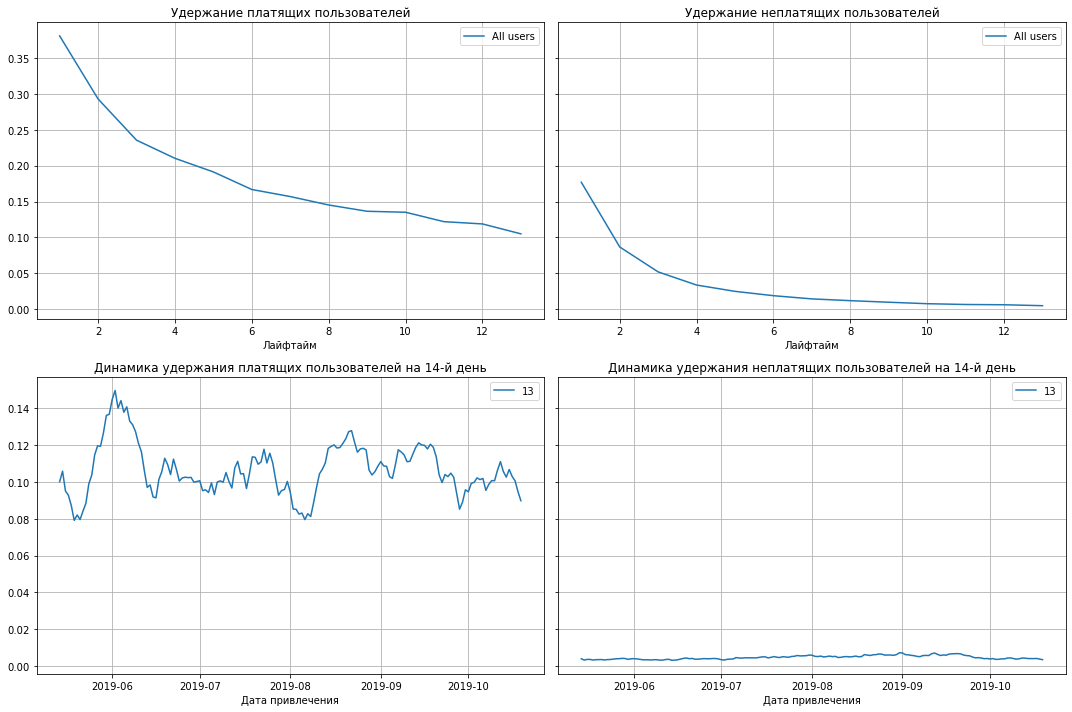

In [29]:
# считаем RR
result_raw, result_grouped, result_in_time = get_retention(
    users_no_organic,
    visits,
    observation_date,
    horizon_days)

# строим графики
plot_retention(result_grouped, result_in_time, horizon_days)

Выводы:

- Удержание платящих пользователей хоть и убывает медленне, чем удержание неплатящих пользователей, но, все же, этот показатель падает достаточно быстро.
- Удержание платящих пользователей подвержено влиянию сезонного фактора, но зависимость не критична.

### Маркетинговые метрики с разбивкой по устройствам

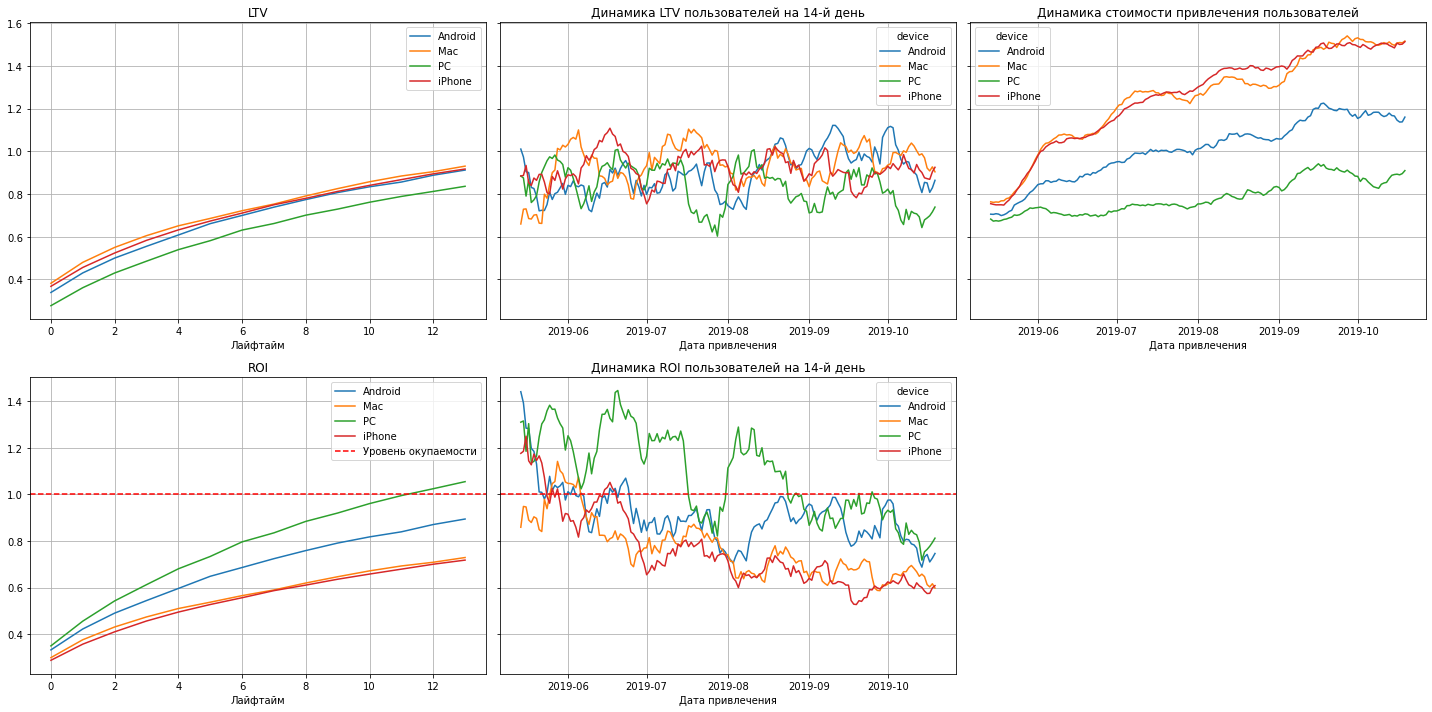

In [30]:
# считаем LTV и ROI с разбивкой по устройствам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    users_no_organic, orders, observation_date, horizon_days, dimensions=['device'])

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Выводы:

- Реклама не окупается. Окупаются только пользователи PC, но в динамике видно, что с сентября и они перестают окупаться. Пользователи Mac и iPhone находятся в числе "аутсайдеров" по окупаемости, но значительная разница в показателях не наблюдается.
- Стоимость привлечения пользователей Mac и iPhone растет быстрее, чем стоимость привлечения пользователей других устройств, но значительная разница в показателях не наблюдается.
- На LTV влияет сезонный фактор, но этот показатель достаточно стабилен для всех устройств.

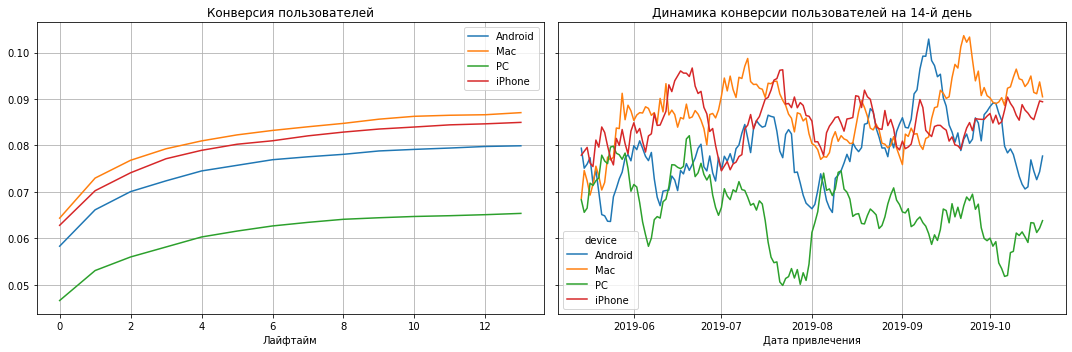

In [31]:
# смотрим CR с разбивкой по устройствам
result_raw, result_grouped, result_in_time = get_conversion(
    users_no_organic,
    orders,
    observation_date,
    horizon_days,
    dimensions=['device'])

plot_conversion(result_grouped, result_in_time, horizon_days)

Вывод: Коверсия пользователей разных устройств постоянно растет; значит, с этим показателем проблем нет.

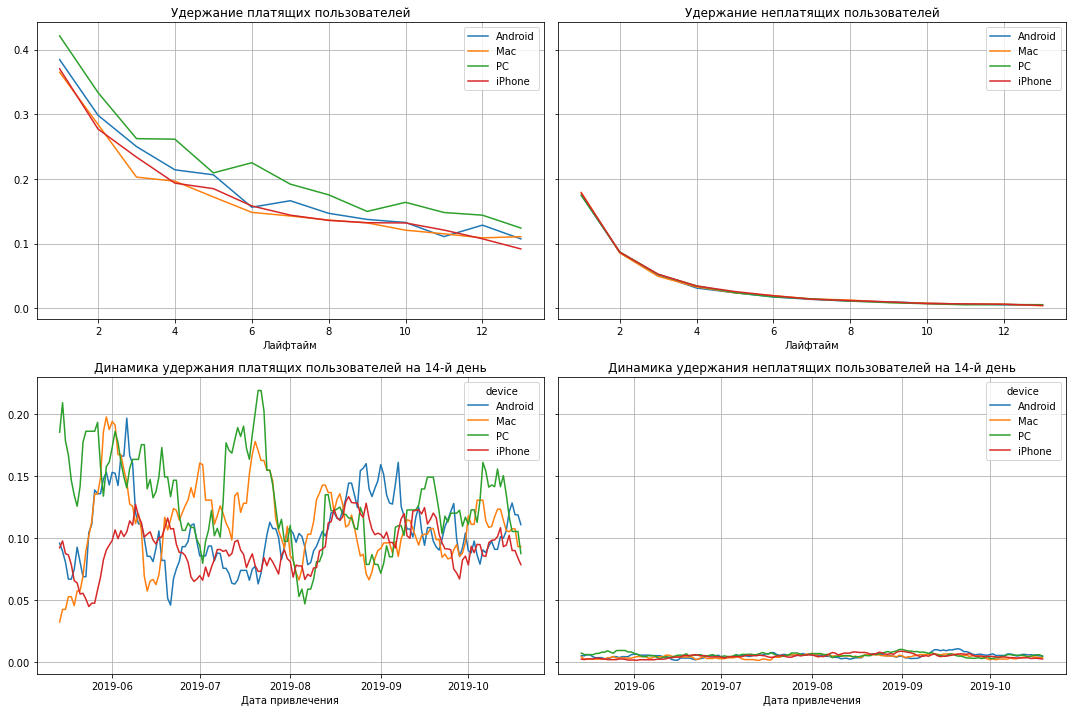

In [32]:
# смотрим RR с разбивкой по устройствам
result_raw, result_grouped, result_in_time = get_retention(
    users_no_organic,
    visits,
    observation_date,
    horizon_days,
    dimensions=['device'])

plot_retention(result_grouped, result_in_time, horizon_days)

Вывод: Среди пользователей разных устройств нет явных "аутсайдеров", которые удерживаются хуже остальных; с этим показателем проблем нет.

### Маркетинговые метрики с разбивкой по источникам

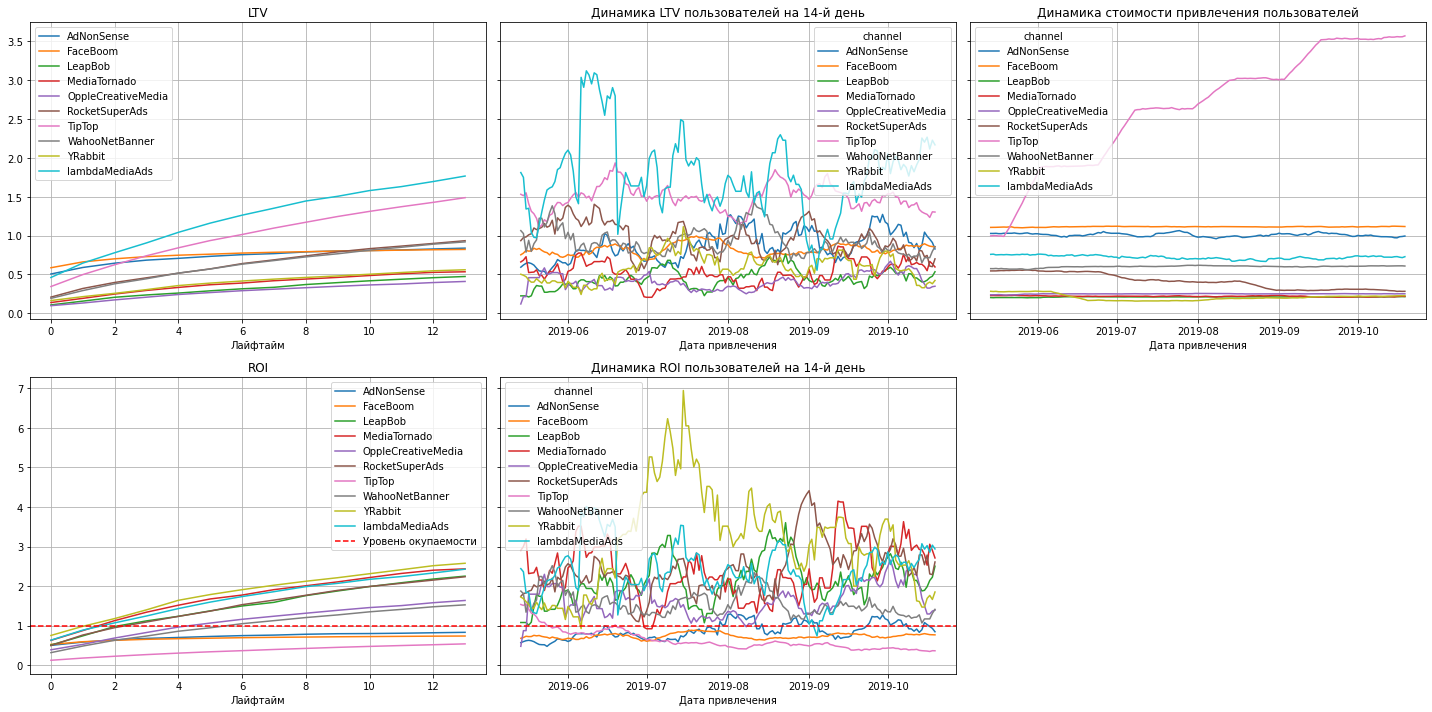

In [33]:
# считаем LTV и ROI с разбивкой по источникам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
     users_no_organic, orders, observation_date, horizon_days, dimensions=['channel'])

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Выводы:

- Привлечение пользователей источниками TipTop, FaceBoom и AdNonSense не окупается; в то время как пользователи, привлеченные другими источниками окупаются.
- Стоимость привлечения пользователей TipTop растет очень быстро; в то время как днамика стоимости привлечения остальных пользователей стабильна.
- На LTV влияет сезонный фактор, но этот показатель достаточно стабилен для пользователй всех источников.

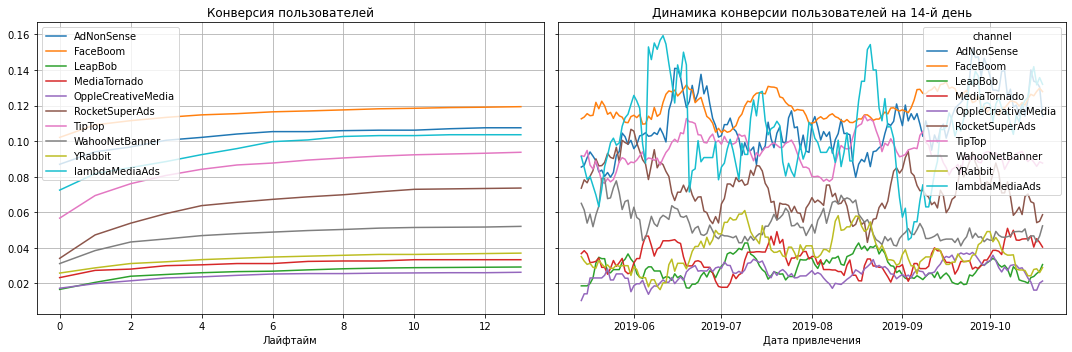

In [34]:
# смотрим CR с разбивкой по источникам
result_raw, result_grouped, result_in_time = get_conversion(
    users_no_organic,
    orders,
    observation_date,
    horizon_days,
    dimensions=['channel'])

plot_conversion(result_grouped, result_in_time, horizon_days)

Вывод: Коверсия пользователей, привлеченных разными источниками, одинаково растет; значит, проблема заключается не в конверсии.

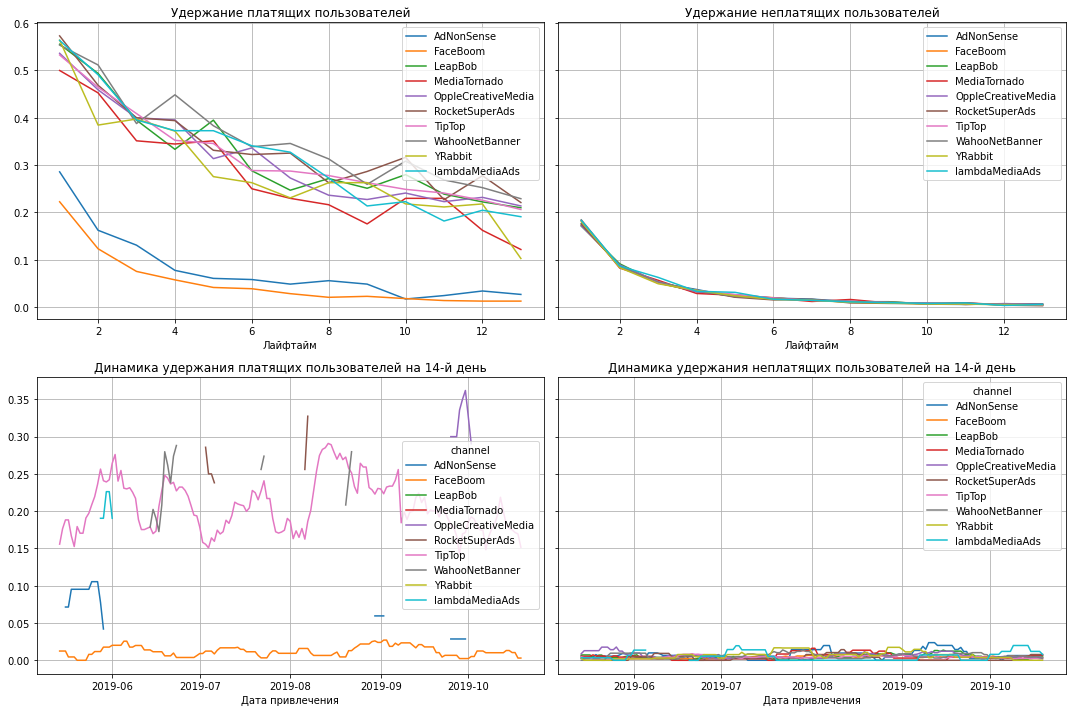

In [35]:
# смотрим RR с разбивкой по источникам
result_raw, result_grouped, result_in_time = get_retention(
    users_no_organic,
    visits,
    observation_date,
    horizon_days,
    dimensions=['channel'])

plot_retention(result_grouped, result_in_time, horizon_days)

Вывод: Удержание платящих пользователей,привлеченных источником FaceBoom и AdNonSense, ниже, чем у пользователей, пришедших из других источников. 

### Маркетинговые метрики с разбивкой по странам

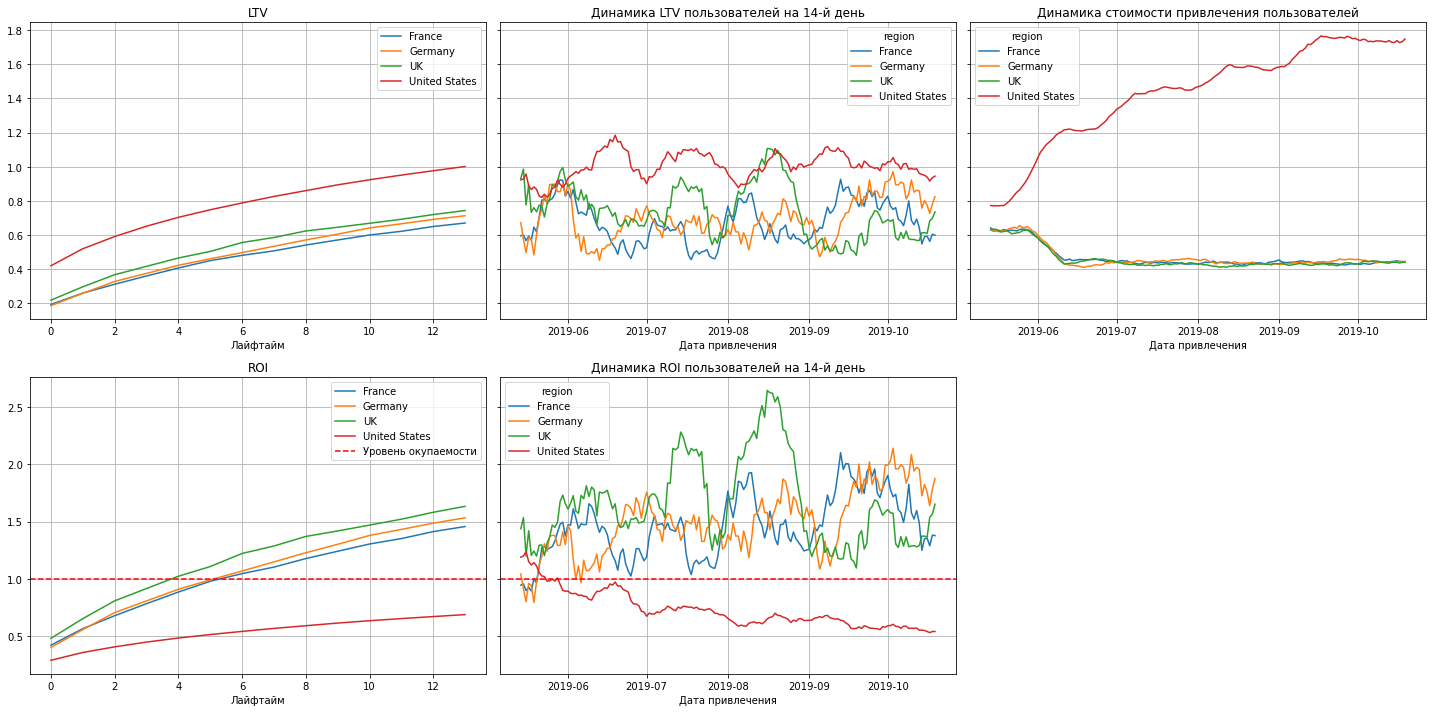

In [36]:
# считаем LTV и ROI с разбивкой по странам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    users_no_organic, orders, observation_date, horizon_days, dimensions=['region'])

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Выводы:

- Привлеченные пользователи из США не окупаются, в отличие от пользователей из других стран.
- Стоимость привлечения пользователей из США стремительно растет; в то время как днамика стоимости привлечения пользователей из других стран стабильна.
- На LTV влияет сезонный фактор, но этот показатель достаточно стабилен для всех стран.

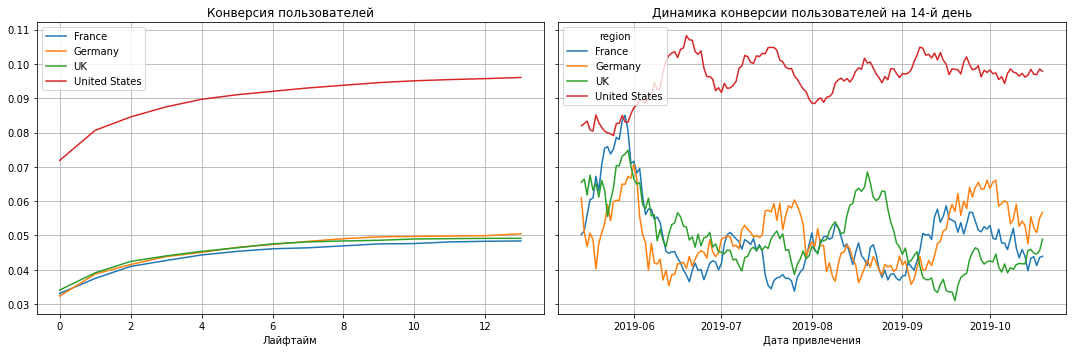

In [37]:
# смотрим CR с разбивкой по странам
result_raw, result_grouped, result_in_time = get_conversion(
    users_no_organic,
    orders,
    observation_date,
    horizon_days,
    dimensions=['region'])

plot_conversion(result_grouped, result_in_time, horizon_days)

Вывод: Коверсия пользователей из США постоянно растет; значит, проблема заключается не в конверсии.

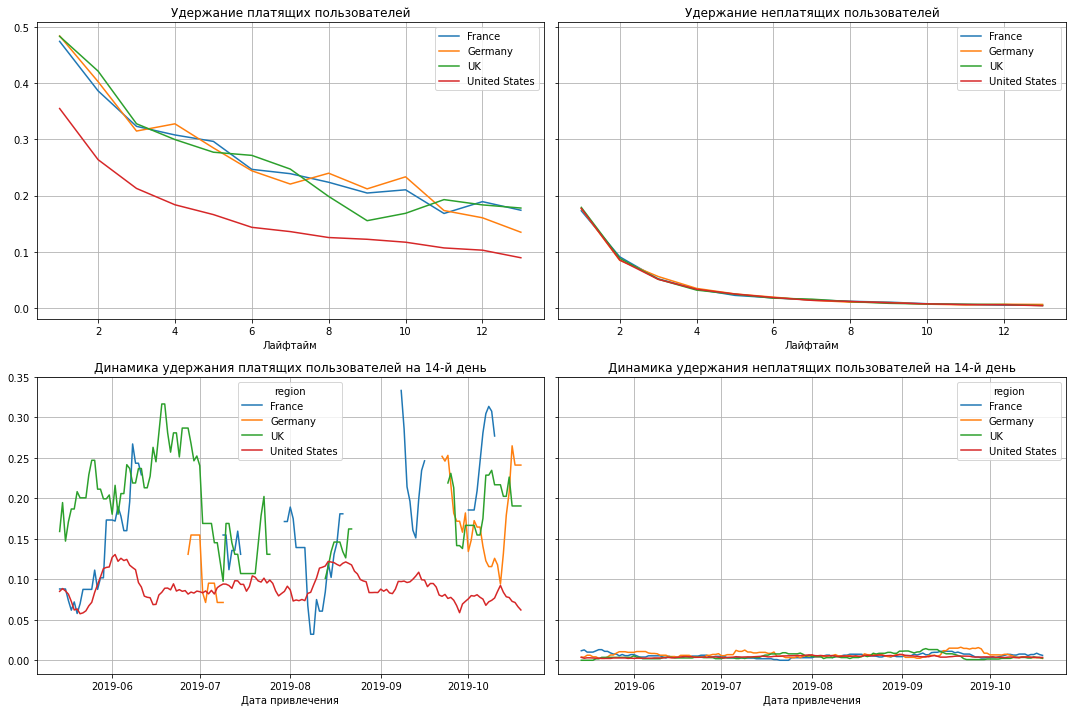

In [38]:
# смотрим RR с разбивкой по странам
result_raw, result_grouped, result_in_time = get_retention(
    users_no_organic,
    visits,
    observation_date,
    horizon_days,
    dimensions=['region'])

plot_retention(result_grouped, result_in_time, horizon_days)

Вывод: Удержание платящих пользователей из США ниже, чем пользователей, пришедших из других стран. 

### Дополнительное исследование США

In [39]:
us_users = users_no_organic.query('region == "United States"') # делаем срез данных

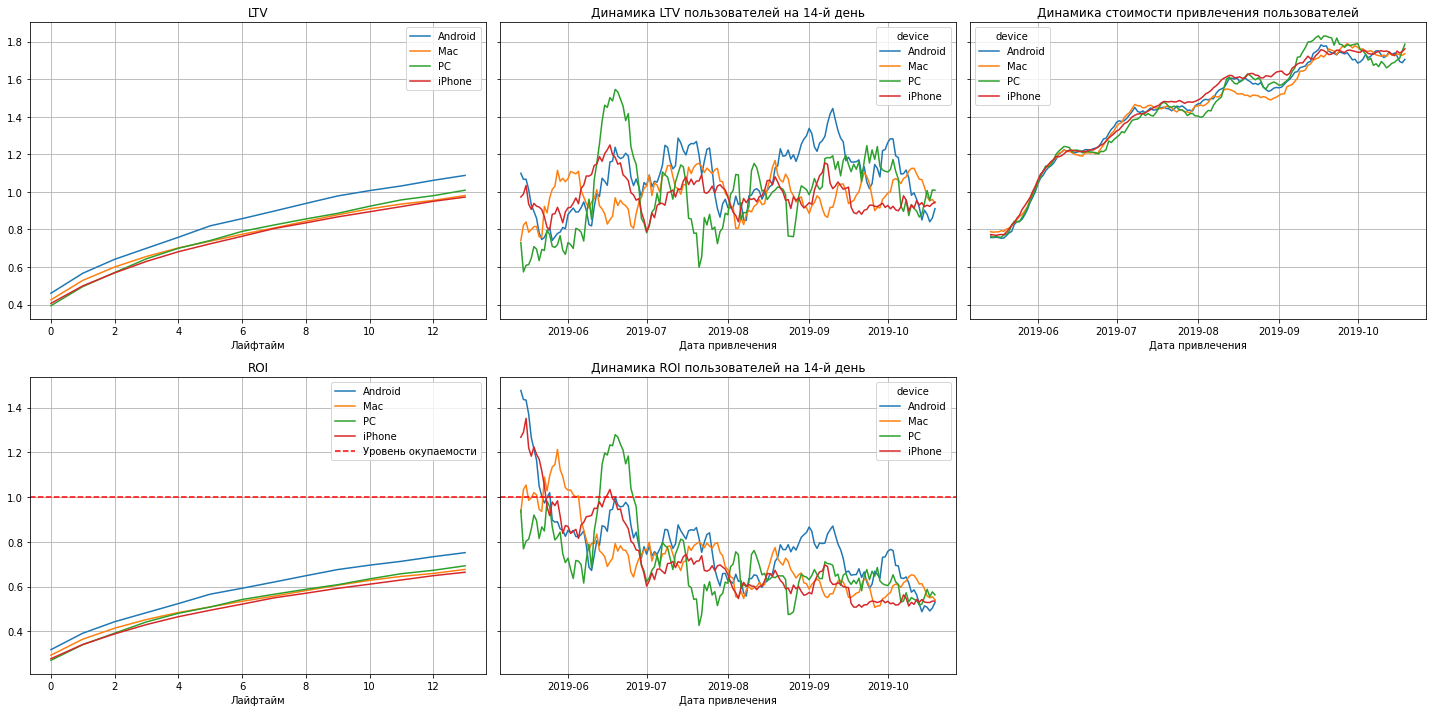

In [40]:
# считаем LTV и ROI с разбивкой по устройствам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    us_users, orders, observation_date, horizon_days, dimensions=['device'])

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Выводы:

- Реклама в США неокупается вне зависимости от устройств, которыми пользуются клиенты. В динамике видно, пользователи PC окупались в краткосрочный период июня, но уже в июле и они перестали окупаться.
- Стоимость привлечения всех пользователей из США стремительно растет.
- На LTV влияет сезонный фактор, но этот показатель достаточно стабилен для всех устройств.

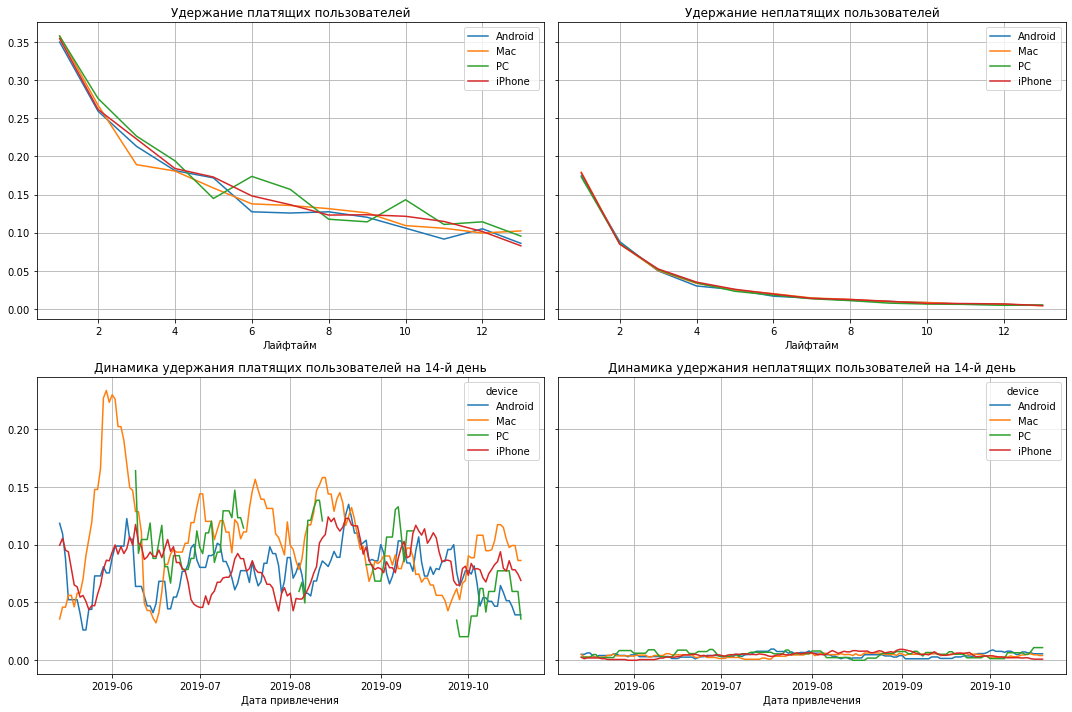

In [41]:
# анализ CR пропускаем, т.к. ранее у пользователей из США не было выявлено проблем с этим показаталем
# смотрим RR с разбивкой по устройствам
result_raw, result_grouped, result_in_time = get_retention(
    us_users,
    visits,
    observation_date,
    horizon_days,
    dimensions=['device'])

plot_retention(result_grouped, result_in_time, horizon_days)

Вывод: Среди пользователей разных устройств нет явных "аутсайдеров", которые удерживаются хуже остальных. Значит, специфических для разных устройств технических проблем, с которыми мог бы быть связан низий уровень удержания этих пользователей, нет.

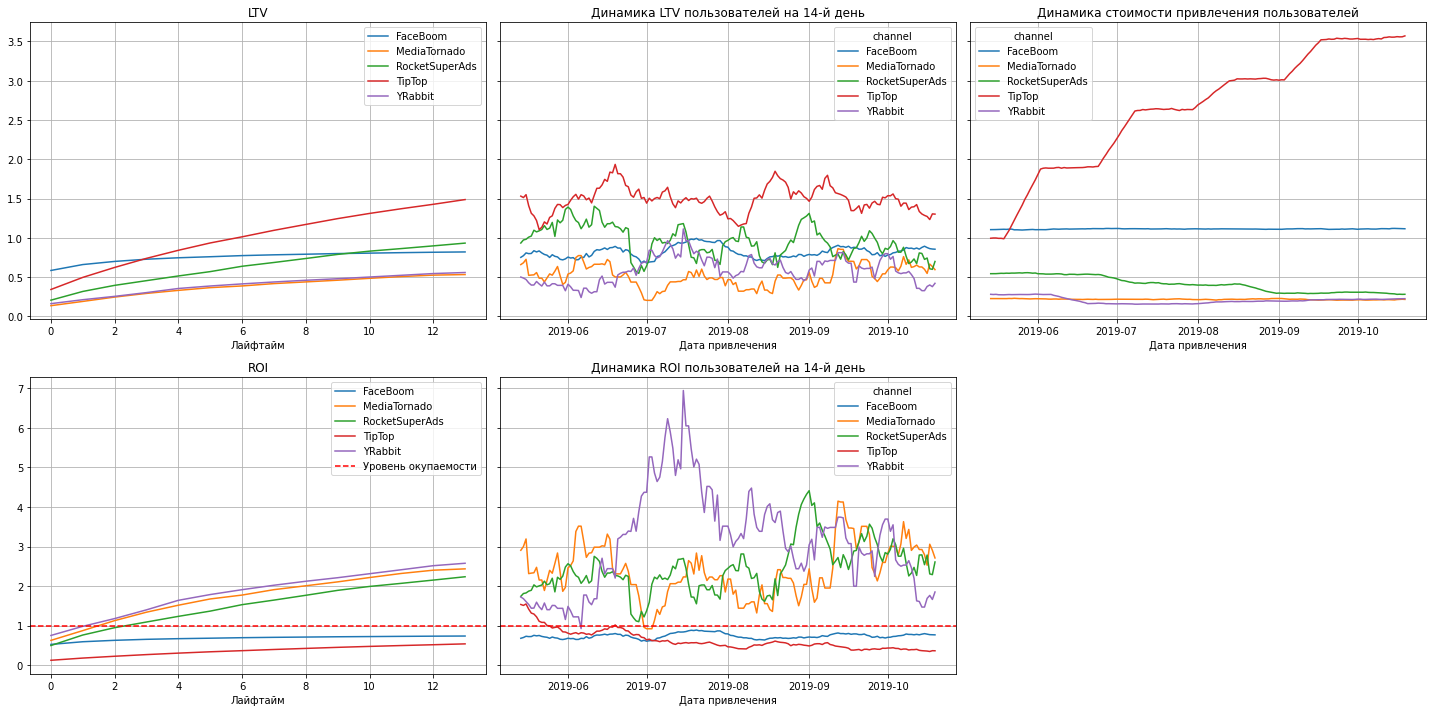

In [42]:
# считаем LTV и ROI с разбивкой по источникам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
     us_users, orders, observation_date, horizon_days, dimensions=['channel'])

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Выводы:

- Среди пользователей из США нет тех, кто пришел из "проблемного" источника AdNonSense.
- Источники YRabbit, MediaTornado, RocketSuperAds одинаково хорошо окупаются.
- Привлечение пользователей источниками TipTop, FaceBoom не окупается; в то время как пользователи, привлеченные другими источниками окупаются.
- Стоимость привлечения пользователей TipTop растет очень быстро; в то время как днамика стоимости привлечения остальных пользователей стабильна.
- На LTV влияет сезонный фактор, но этот показатель достаточно стабилен для пользователй всех источников.

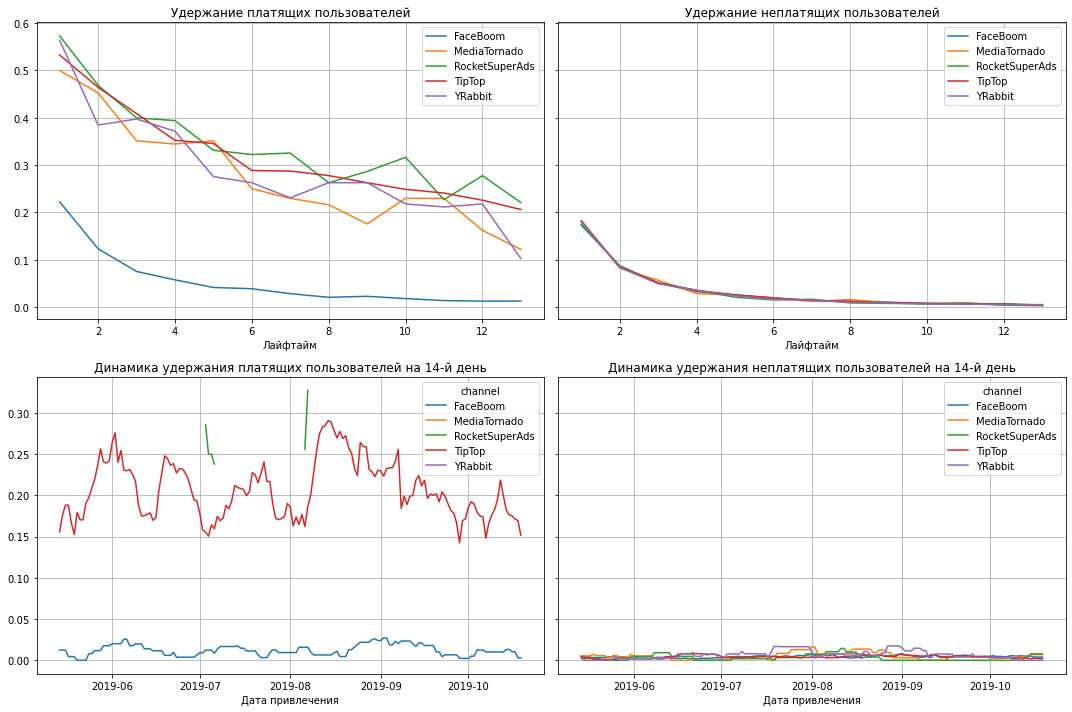

In [43]:
# анализ CR пропускаем, т.к. ранее у пользователей из США не было выявлено проблем с этим показаталем
# смотрим RR с разбивкой по источникам
result_raw, result_grouped, result_in_time = get_retention(
    us_users,
    visits,
    observation_date,
    horizon_days,
    dimensions=['channel'])

plot_retention(result_grouped, result_in_time, horizon_days)

Вывод: Удержание платящих пользователей из США, привлеченных источником FaceBoom, ниже, чем у пользователей, пришедших из других источников. 

### Дополнительный анализ источников FaceBoom, TipTop, AdNonSense

In [44]:
ch_users = (
    users_no_organic.query('channel == "FaceBoom" | channel == "TipTop" | channel == "AdNonSense"') # делаем срез данных
)

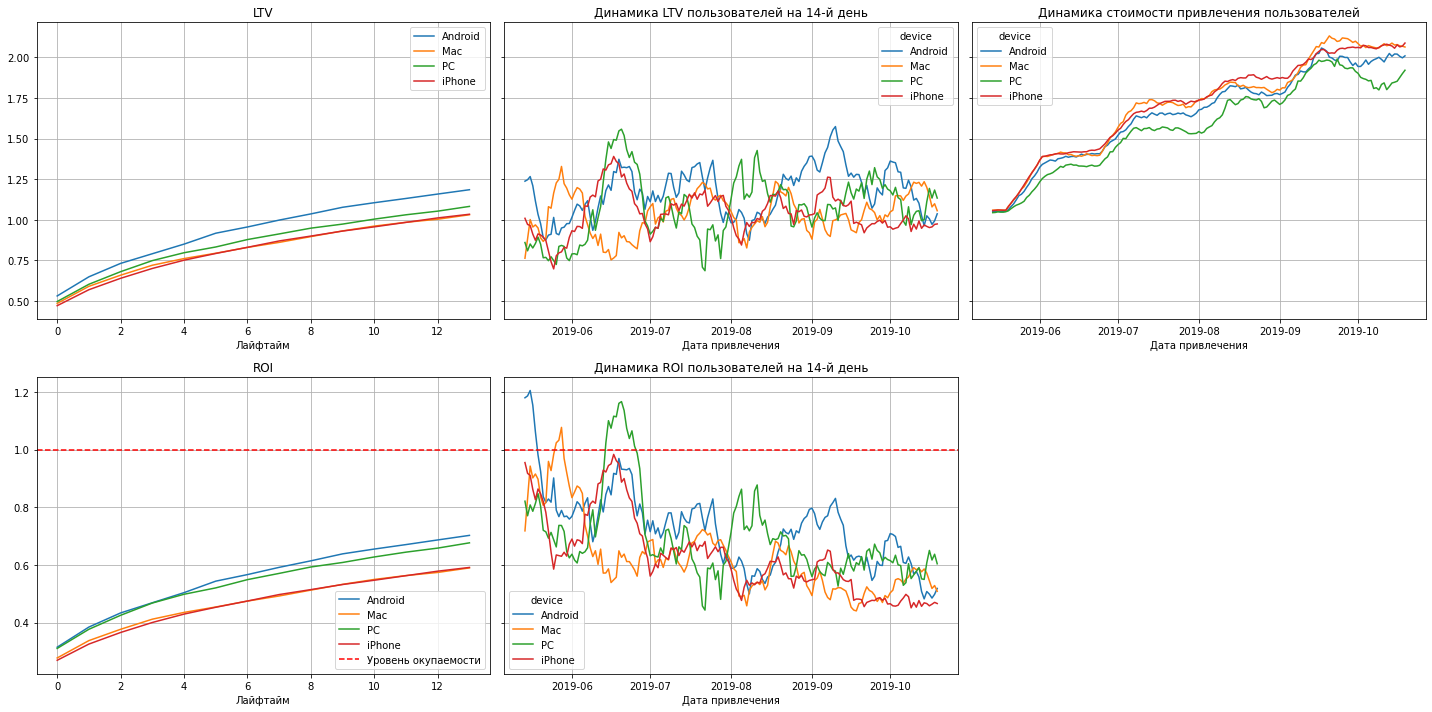

In [45]:
# считаем LTV и ROI с разбивкой по устройствам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    ch_users, orders, observation_date, horizon_days, dimensions=['device'])

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Выводы:

- Реклама неокупается вне зависимости от устройства пользователя. В динамике видно, пользователи PC окупались в краткосрочный период июня, но уже в июле и они перестали окупаться.
- Стоимость привлечения пользователей всех устройств стремительно растет.
- На LTV влияет сезонный фактор, но этот показатель достаточно стабилен для всех устройств.

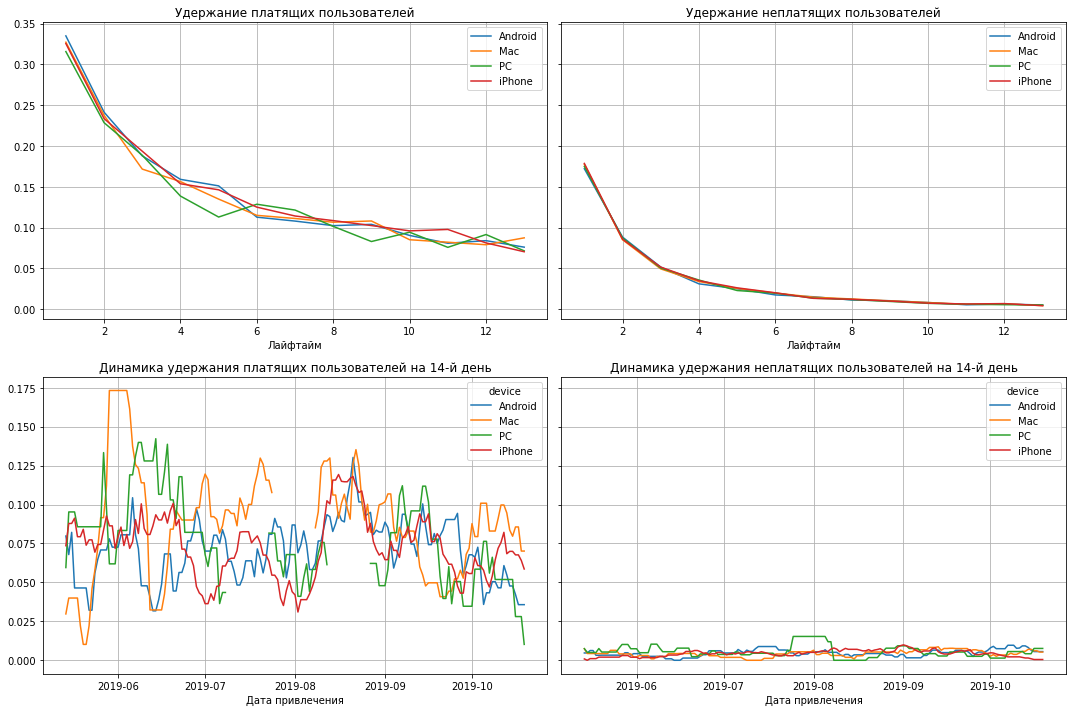

In [46]:
# анализ CR пропускаем, т.к. ранее у пользователей, привлеченных исследуемыми источниками,
# не было выявлено проблем с этим показаталем
# смотрим RR с разбивкой по устройствам
result_raw, result_grouped, result_in_time = get_retention(
    ch_users,
    visits,
    observation_date,
    horizon_days,
    dimensions=['device'])

plot_retention(result_grouped, result_in_time, horizon_days)

Вывод: Среди пользователей разных устройств нет явных "аутсайдеров", которые удерживаются хуже остальных. Значит, специфических для разных устройств технических проблем, с которыми мог бы быть связан низий уровень удержания пользователей, привлеченных источниками TipTop, FaceBoom, AdNonSense, нет.

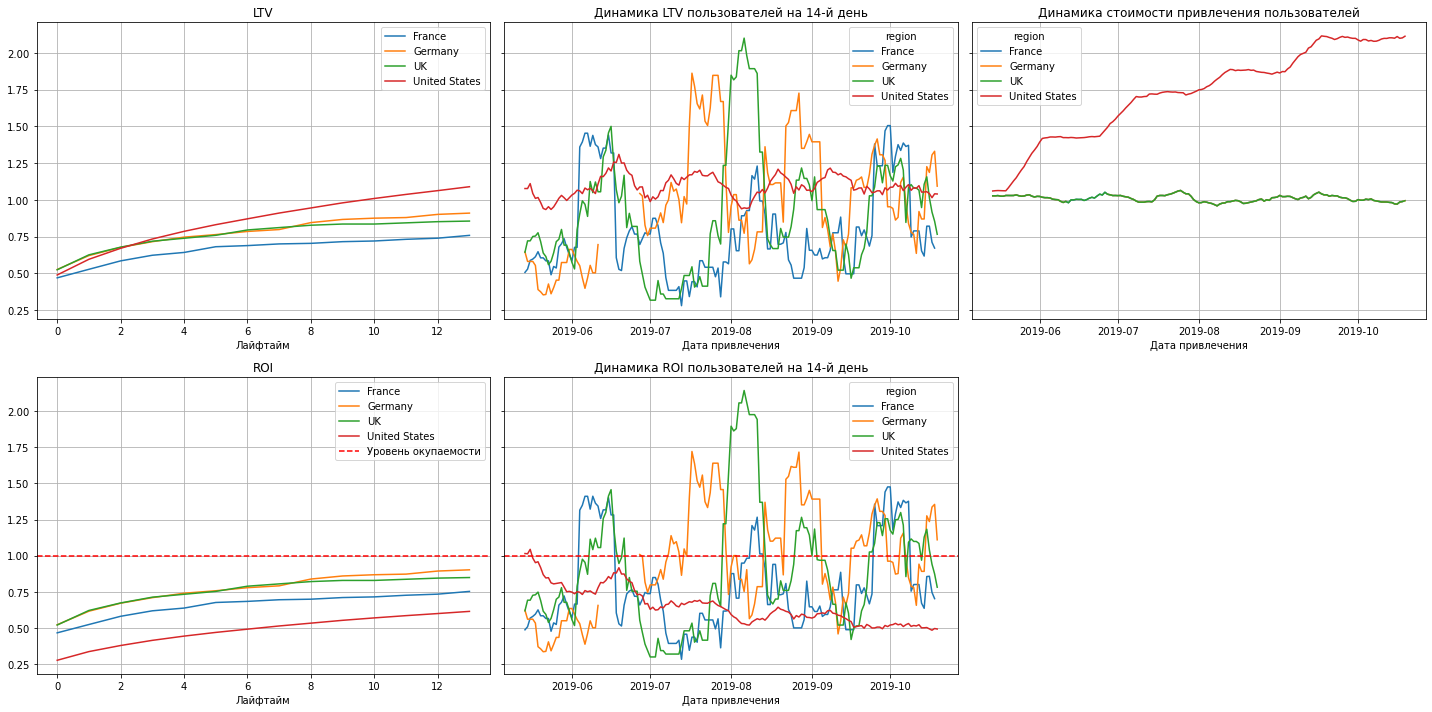

In [47]:
# считаем LTV и ROI с разбивкой по странам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    ch_users, orders, observation_date, horizon_days, dimensions=['region'])

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Выводы:

- Источники TipTop, FaceBoom, AdNonSense привлекают пользователей из разных стран.
- Привлечение пользователей этими источниками не окупается вне зависимости от страны, в которой находится пользователь.
- Стоимость привлечения пользователей из США стремительно растет.
- На LTV влияет сезонный фактор.

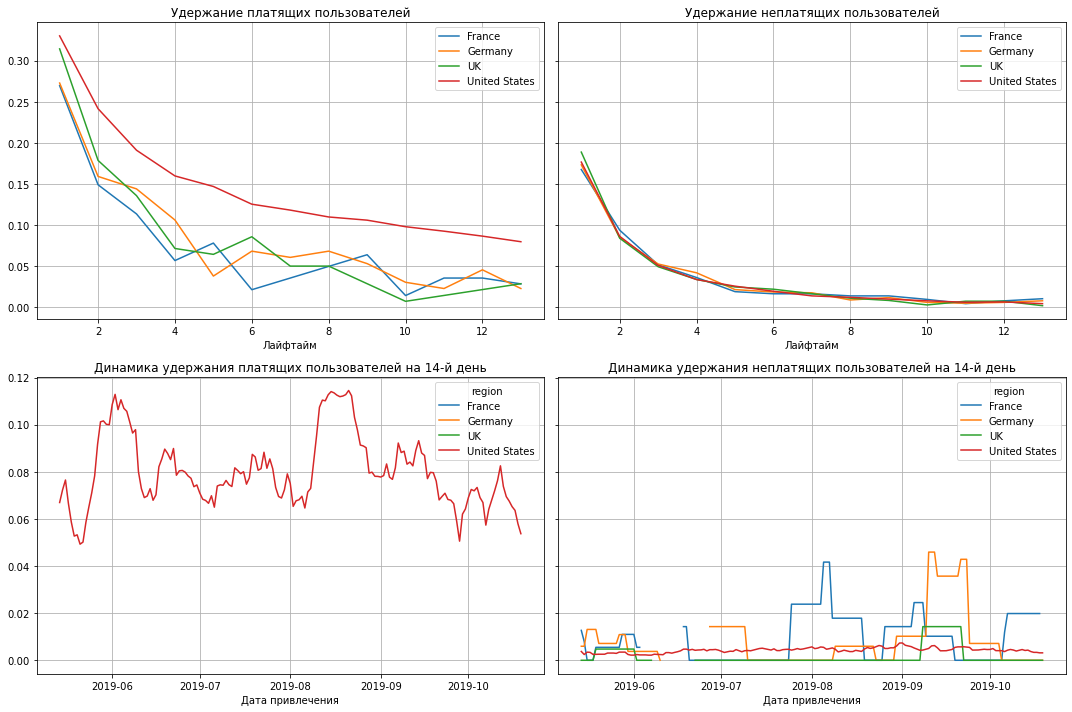

In [48]:
# анализ CR пропускаем, т.к. ранее у пользователей, привлеченных исследуемыми источниками,
# не было выявлено проблем с этим показаталем
# смотрим RR с разбивкой по странам
result_raw, result_grouped, result_in_time = get_retention(
    ch_users,
    visits,
    observation_date,
    horizon_days,
    dimensions=['region'])

plot_retention(result_grouped, result_in_time, horizon_days)

Вывод: Среди пользователей разных стран нет явных "аутсайдеров", которые удерживаются хуже остальных. Значит, географический фактор не влияет на низкий уровень удержания пользователей, привлеченных исследуемыми источниками.

### Поиск перспективных источников в Европе

In [49]:
ec_users = users_no_organic.query('region != "United States"') # делаем срез данных

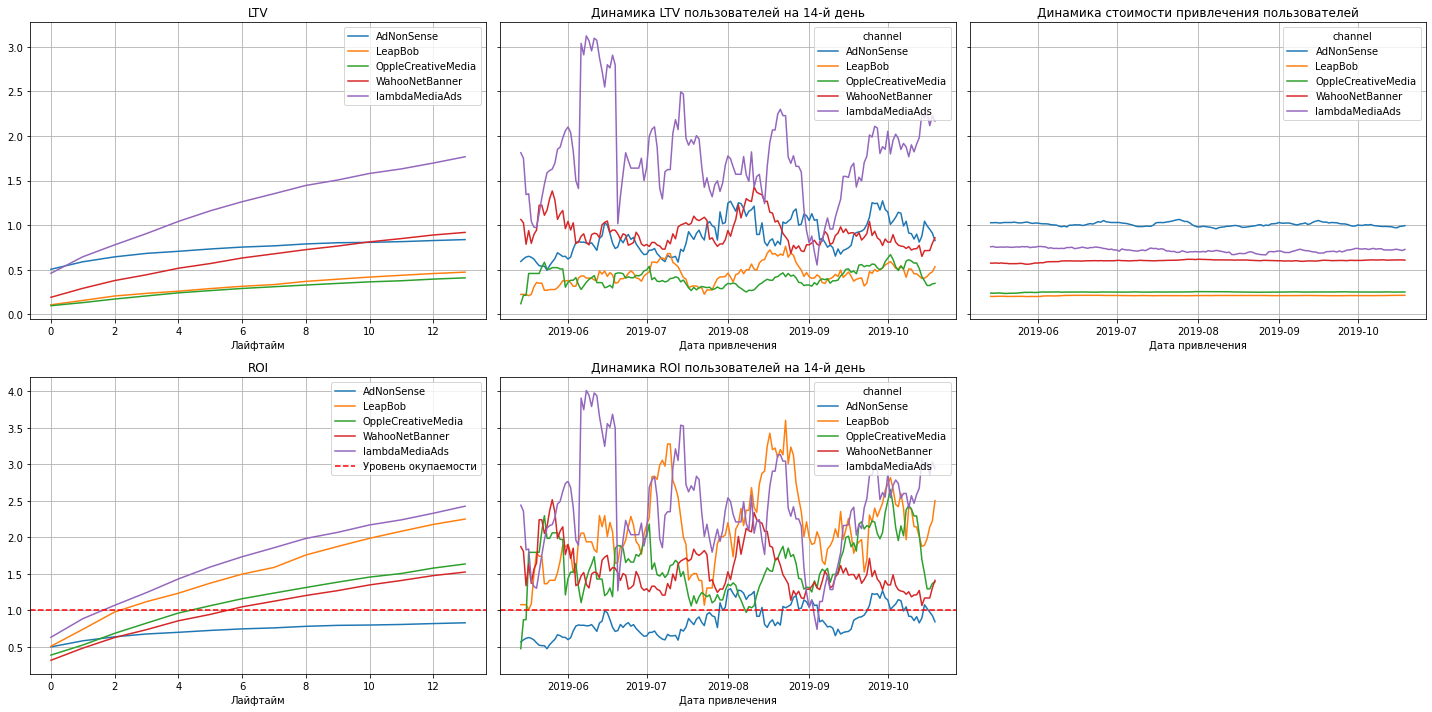

In [50]:
# считаем LTV и ROI с разбивкой по источникам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
     ec_users, orders, observation_date, horizon_days, dimensions=['channel'])

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Выводы:

- Привлечение пользователей источником AdNonSense не окупается; в то время как пользователи, привлеченные другими источниками окупаются.
- Стоимость привлечения пользователей вне зависимости от источника привлечения стабильна.
- На LTV влияет сезонный фактор, но этот показатель достаточно стабилен для пользователй всех источников.
- Наиболее окупаемые источники: lambdaMediaAds, LeapBob.

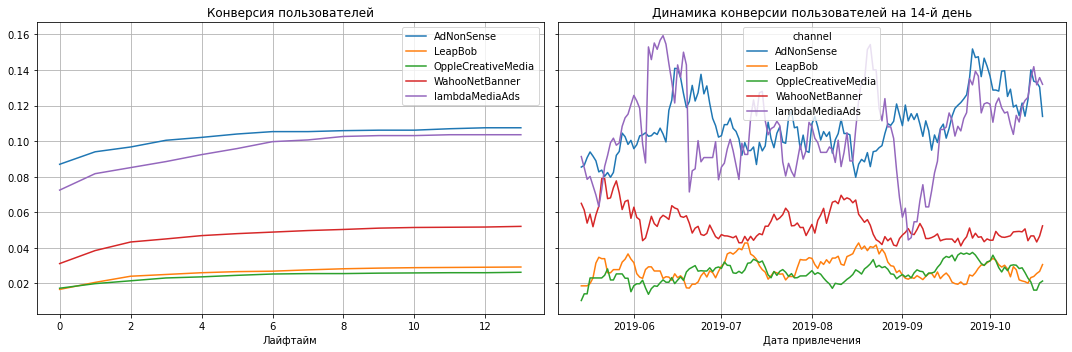

In [51]:
# смотрим CR с разбивкой по источникам
result_raw, result_grouped, result_in_time = get_conversion(
    ec_users,
    orders,
    observation_date,
    horizon_days,
    dimensions=['channel'])

plot_conversion(result_grouped, result_in_time, horizon_days)

Вывод: Коверсия пользователей, привлеченных разными источниками, одинаково растет.

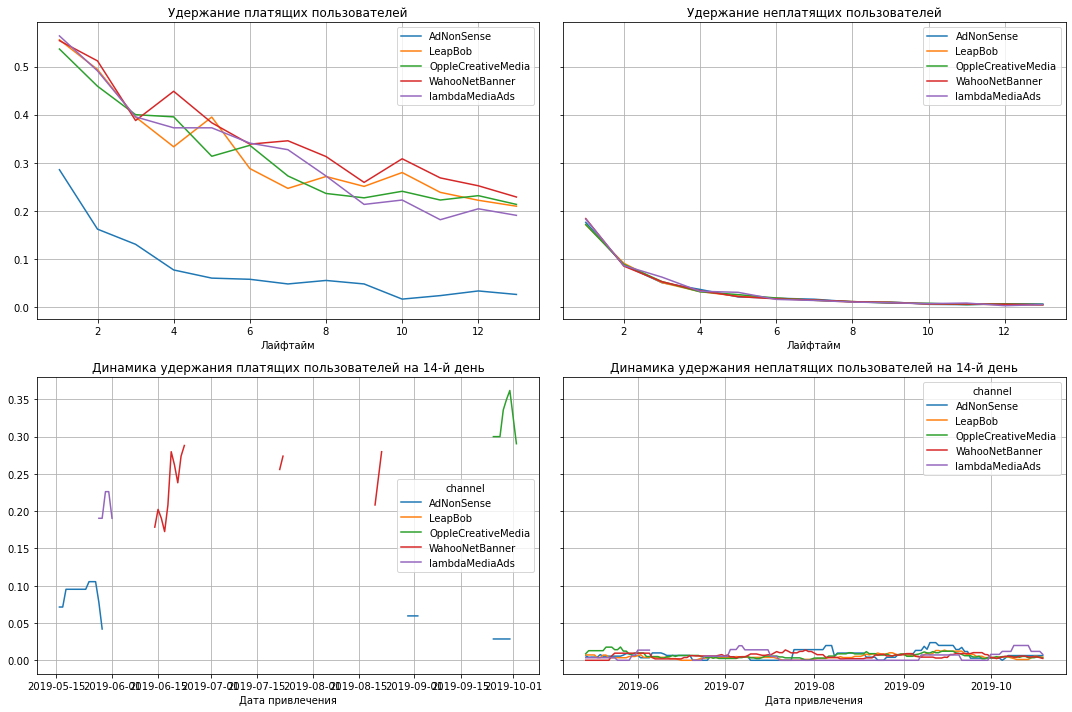

In [52]:
# смотрим RR с разбивкой по источникам
result_raw, result_grouped, result_in_time = get_retention(
    ec_users,
    visits,
    observation_date,
    horizon_days,
    dimensions=['channel'])

plot_retention(result_grouped, result_in_time, horizon_days)

Вывод: Явных "аутсайдеров", за исключением источника AdNonSense, не наблюдается. Значит, остальные источники привлекают более качественную аудиторию.

## Вывод

### Цель проведенного исследования
Разобраться в причинах неэффективности привлечения пользователей развлекательного приложения Procrastinate Pro+. Дать рекомендации для отдела маркетинга.**

Для этого были проанализированы данные, пердоставленные компанией-разработчиком приложения Procrastinate Pro+, о пользователях, привлечённых с 01.05.2019 по 27.10.2019. Момент анализа: 01.11.2019; горизонт анализа: 14 дней.

### Общая характеристика пользователей 
- Средняя стоимость привлечения одного пользователя - 1.13 доллара.
- Источники рекламы TipTop и FaceBoom поделили между собой большую часть маркетингового бюджета компании. Доля вложений в TipTop составляет 52%, доля вложений в FaceBoom составляет 31%.
- Число органических пользователей превышает число пользователей, привлеченных любым, из используемых компанией, каналом; однако, доля платящих пользователей среди органиков очень мала, всего - 2.1%.
- Портрет среднестатистического платящего пользователя: страна, из которой он пришел - США; используемое устройство - Mac или iPhone; источник, который его привлек - FaceBoom или TipTop.

### Общая характеристика бизнес-показателей
- Реклама не окупается. Окупаемость в конце второй недели около ~ 80%.
- Стоимость привлечения одного пользователя растет из месяца в месяц, что не является нормой. 
- На пожиненную ценность клиента влияет сезонный фактор, но этот показатель достаточно стабилен.
- Конверсия неплатящих пользователей в платящих стабильно растет.
- Удержание платящих пользователей хоть и убывает медленне, чем удержание неплатящих пользователей, но, все же, этот показатель падает достаточно быстро.

### Выводы
Результаты детального анализа говорят нам о наличии трех проблемных зон:
- Пользователи из США не удерживаются в приложении, вследствие чего и не окупаются.
- Пользователи, привлеченные источниками FaceBoom и AdNonSense, не удерживаются в приложении, вследствие чего и не окупаются.
- Стоимость привлечения пользователей источником TipTop слишком велика. Эта категория пользователей не окупается из-за высокой стоимости рекламной компании.

Рассмотрим каждый из них более подробно:
- США. Неокупаемость пользователей из США связана напрямую с основными источниками привлечения, такими как TipTop и FaceBoom. Пользователи, привлеченные источником FaceBoom, плохо удерживаются в приложении, вследствие чего - не окупаются. Стоимость привлечения пользователей источником TipTop слишком велика, вследствие чего они не окупаются.

- FaceBoom и AdNonSense. Неокупаемость пользователей, привлеченных этими источниками, связана напрямую с низким уровнем их удержаниях в приложении. Удержание пользователей из FaceBoom и AdNonSense не связано ни с географическим фактором их расположения, ни со специфификой их устройств. Вероятно, что эти источники привлекают некачественную аудиторию.

- TipTop. Стоимость привлечения пользователей источником TipTop слишком велика, вследствие чего, пользователи, привлеченные этим источником, не окупаются.

Отдельно рассмотрим Европу:
- В целом, пользователи из Европы окупаются. Здесь стоит обратить внимание на "проблемный" источник AdNonSense, который работает только с европейской аудиторией. А также, стоит обратить внимание на то, что количество пользователей из Европы значительно меньше, чем количество пользоваталей из США.


### Рекомендации
- Провести опрос пользователей, привлеченных источником FaceBoom и AdNonSense, на предмет их мотивированности в дальнейшем использовании приложения, т.к. вполне вероятно, что эти источники привлекают некачественную аудиторию. 
- Урегулировать стоимость рекламной компании TipTop.
- Начать разрабатывать другие уже имеющиеся эффективные источники привлечения пользователей из США. Например, RocketSuperAds хорошо окупается и привлекает пользователей, которые удерживаются в приложении.
- Привлечь новых пользователей из Европы. Например, с помощью разработки уже имеющихся эффективных источников привлечения, таких как lambdaMediaAds и LeapBob; эти источники хорошо окупаются и привлекают пользователей, которые удерживаются в приложении.